SQLite suporta funções de **date** e **time**:

- `date(timestring, modifier, modifier, ...)`
- `time(timestring, modifier, modifier, ...)`
- `datetime(timestring, modifier, modifier, ...)`
- `julianday(timestring, modifier, modifier, ...)`
- `strftime(format, timestring, modifier, modifier, ...)`

Todas recebem uma string de tempo como argumento e podem ser acompanhadas de modificadores. 

Este notebook apresenta:

 - Exemplos de funções date e time 
 - Criar uma tabela e indíce de temperatura
 - Inserir dados na tabela
- Consultar dados na tabela

In [2]:
#pacotes

from random import uniform, choice
import time
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

In [3]:
con = sqlite3.connect('../primeiro_banco')
cur = con.cursor()
print('conexão aberta')

conexão aberta


Exemplo com datas e funções de datas

In [6]:
#Visualizar a data atual

query = 'SELECT DATE("now") AS data_atual'

df = pd.read_sql_query(query, con)
df

,data_atual
0,2023-01-03


In [11]:
#Último dia do mês atual

query = 'SELECT DATE("now", "start of month", "+1 month", "-1 day") AS ultimo_dia'

df = pd.read_sql_query(query, con)
df

,ultimo_dia
0,2023-01-31


In [13]:
#data da primeira terça feira de outubro do ano corrente

query = 'SELECT DATE("now", "start of year", "+9 months", "weekday 2") AS primeira_terca_feira'

df = pd.read_sql_query(query, con)
df

,primeira_terca_feira
0,2023-10-03


Tabela de série temporal de temperatura

In [24]:
#criar tabela

con.executescript('''
DROP TABLE IF EXISTS Temperature;
CREATE TABLE Temperature (
    Timestamp DATETIME NOT NULL,
    Temperature NUMERIC NOT NULL
    );
'''
)

con.commit()

In [25]:
#criar índice para a coluna Timestamp

con.execute('CREATE UNIQUE INDEX idx_timestamp ON Temperature (Timestamp);')

con.commit()

In [28]:
query = 'SELECT * FROM Temperature'

df = pd.read_sql_query(query, con)
df

,Timestamp,Temperature


In [30]:
#inserir dados

def dt(days):
    return timedelta(days=days)

N_rows = 500
now = datetime.now()

for i in range(N_rows):
    timestamp = now - dt(days=(N_rows-i))
    temperature = uniform(18, 26)
    con.execute(f'INSERT INTO Temperature VALUES ("{timestamp}", "{temperature}");')
    con.commit()

In [32]:
query = 'SELECT * FROM Temperature LIMIT 5'

df = pd.read_sql_query(query, con)
df

,Timestamp,Temperature
0,2021-08-21 11:34:50.711019,18.916893
1,2021-08-22 11:34:50.711019,20.689565
2,2021-08-23 11:34:50.711019,23.393948
3,2021-08-24 11:34:50.711019,25.135592
4,2021-08-25 11:34:50.711019,23.200781


In [33]:
#filtros

query = '''
SELECT Timestamp as Date, Temperature
FROM Temperature
WHERE Date <= "2021-12-31"
'''

df = pd.read_sql_query(query, con)
df

,Date,Temperature
0,2021-08-21 11:34:50.711019,18.916893
1,2021-08-22 11:34:50.711019,20.689565
2,2021-08-23 11:34:50.711019,23.393948
3,2021-08-24 11:34:50.711019,25.135592
4,2021-08-25 11:34:50.711019,23.200781
...,...,...
127,2021-12-26 11:34:50.711019,18.898051
128,2021-12-27 11:34:50.711019,19.138006
129,2021-12-28 11:34:50.711019,25.747900
130,2021-12-29 11:34:50.711019,23.636503


In [34]:
#consultar dados de um ano em específico

query = '''
SELECT Timestamp AS Date, Temperature
FROM Temperature
WHERE CAST(strftime("%Y", Date) AS INTEGER) = 2021
'''

df = pd.read_sql_query(query, con)
df

,Date,Temperature
0,2021-08-21 11:34:50.711019,18.916893
1,2021-08-22 11:34:50.711019,20.689565
2,2021-08-23 11:34:50.711019,23.393948
3,2021-08-24 11:34:50.711019,25.135592
4,2021-08-25 11:34:50.711019,23.200781
...,...,...
128,2021-12-27 11:34:50.711019,19.138006
129,2021-12-28 11:34:50.711019,25.747900
130,2021-12-29 11:34:50.711019,23.636503
131,2021-12-30 11:34:50.711019,23.045454


In [36]:
#Agregar anualmente

query = '''
SELECT strftime("%Y", Timestamp) AS Year,
    AVG(Temperature) AS mean_temperature,
    MAX(Temperature) AS max_temperature,
    MIN(Temperature) AS min_temperature
FROM Temperature
GROUP BY Year
'''

df = pd.read_sql_query(query, con)
df

,Year,mean_temperature,max_temperature,min_temperature
0,2021,21.972199,25.998496,18.008933
1,2022,21.905698,25.985695,18.041178
2,2023,21.430044,22.810584,20.049503


In [41]:
#visualizar os dados

query = 'SELECT DATETIME(Timestamp) as date, Temperature FROM Temperature'

ts = pd.read_sql_query(query, con)
ts.set_index('date', inplace=True)
ts.index = pd.to_datetime(ts.index)
ts.head()


,Temperature
date,
2021-08-21 11:34:50,18.916893
2021-08-22 11:34:50,20.689565
2021-08-23 11:34:50,23.393948
2021-08-24 11:34:50,25.135592
2021-08-25 11:34:50,23.200781


<AxesSubplot: xlabel='date'>

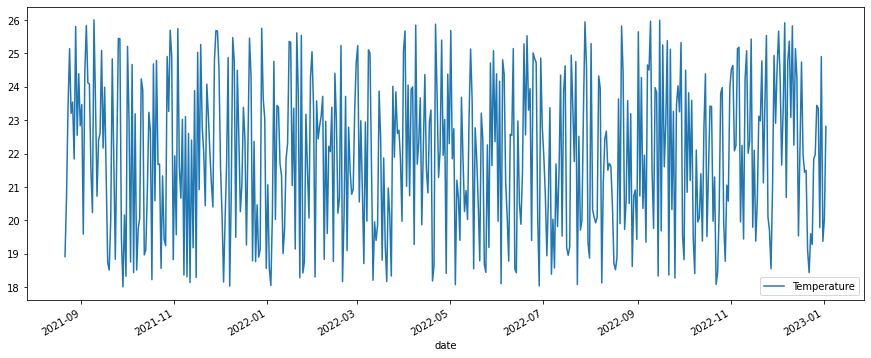

In [44]:
ts.plot(figsize=(15, 6))

In [45]:
con.close()